In [1]:
import os
os.chdir("../")

from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel, SpottingModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
# from modules.Visualiser import collateVisGCN, Visualiser
from modules.GameAnalysis import GamaAnalysis
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params
import torch_geometric

In [8]:
@dataclass
class Args:
    # DATA
    datapath="../football_games"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 10
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GAT"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    # VLAD pooling if applicable
    vocab_size=None
    pooling=None

    # SPOTTING MODULE
    sgementation_path = None
    freeze_model = None
    spotting_fps = 1



In [3]:
args_GCN = {
    "backbone_player": "GCN",
    "sgementation_path": "backbone_GCN.pth.tar",
    "freeze_model": True,
    "vocab_size": None,
    "pooling": None
}

args_GIN = {
    "backbone_player": "GIN",
    "sgementation_path": "backbone_GIN.pth.tar",
    "freeze_model": True,
    "vocab_size": None,
    "pooling": None
}

args_GAT = {
    "backbone_player": "GAT",
    "sgementation_path": "backbone_GAT.pth.tar",
    "freeze_model": True,
    "vocab_size": None,
    "pooling": None
}

args_NetVLAD = {
    "backbone_player": "GCN",
    "sgementation_path": "CALF_NetVLAD_GCN_temporal.pth.tar",
    "freeze_model": True,
    "vocab_size": 16,
    "pooling": "NetVLAD"
}


model_paths = {
    "models/spotting_GCN.pth.tar": args_GCN, 
    "models/spotting_GIN.pth.tar": args_GIN, 
    "models/spotting_GAT.pth.tar": args_GAT, 
    "models/spotting_NetVladGCN.pth.tar": args_NetVLAD}

In [4]:
args = Args
# Storage for all statistics
precisions = np.empty((0, args.annotation_nr+1))
recalls = np.empty((0, args.annotation_nr+1))
f1_scores = np.empty((0, args.annotation_nr+1))
map_scores = np.empty((0, args.annotation_nr+1))

# Storage for all statistics
for model_path in model_paths.keys():
    for key, value in model_paths[model_path].items():
        setattr(args, key, value)
 
    model = torch.load(model_path)
    game_analyser = GamaAnalysis(args, model)
    
    # results, annotations = game_analyser.predict_game(game_index=0, seg_model=True, calibrate=False, ann=None)
    
    # Calculate map_score
    map_score = game_analyser.all_test_games_evaluation(args, last_game_index=4, seg_model=False, calibrate=True, type_eval="map_evaluation")
    # print(f"\n{model_paths[model_path]['backbone_player']}: {map_scores.shape} {map_score.reshape(1,-1).shape}")
    map_scores = np.concatenate([map_scores, map_score.reshape(1,-1)], axis=0)
    
    # Calculate other metrics
    precision, recall, f1 = game_analyser.all_test_games_evaluation(args, last_game_index=4, seg_model=False, calibrate=True, type_eval="clip_based_precision_recall")
    # print(f"\n{model_paths[model_path]['backbone_player']}: {precision.shape}")
    precision = np.concatenate((np.array([np.mean(precision)]), precision))
    recall = np.concatenate((np.array([np.mean(recall)]), recall))
    f1_score = np.concatenate((np.array([np.mean(f1)]), f1))
    
    # Concatenate scores
    precisions = np.concatenate([precisions, precision.reshape(1,-1)], axis=0)
    recalls = np.concatenate([recalls, recall.reshape(1,-1)], axis=0)
    f1_scores = np.concatenate([f1_scores, f1_score.reshape(1,-1)], axis=0)



Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


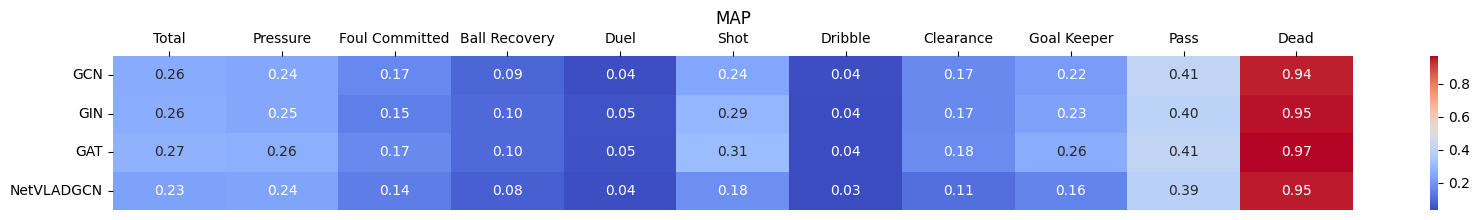

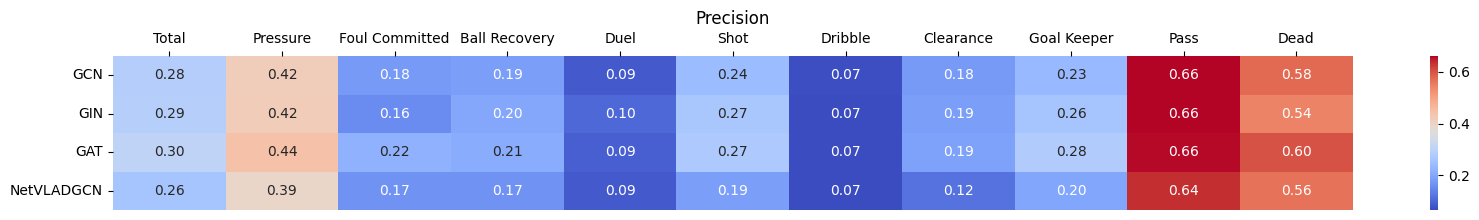

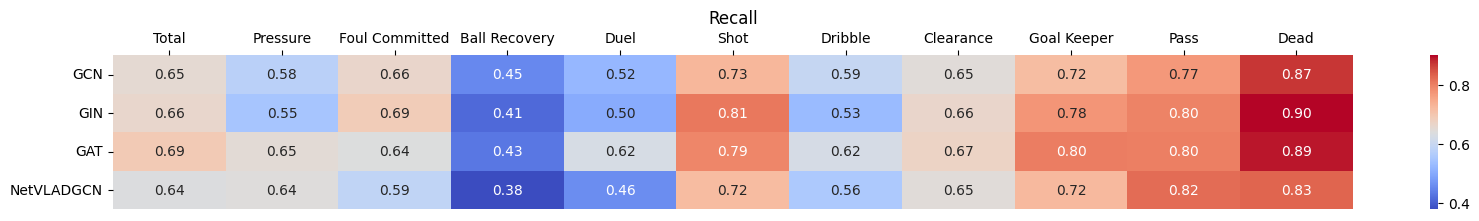

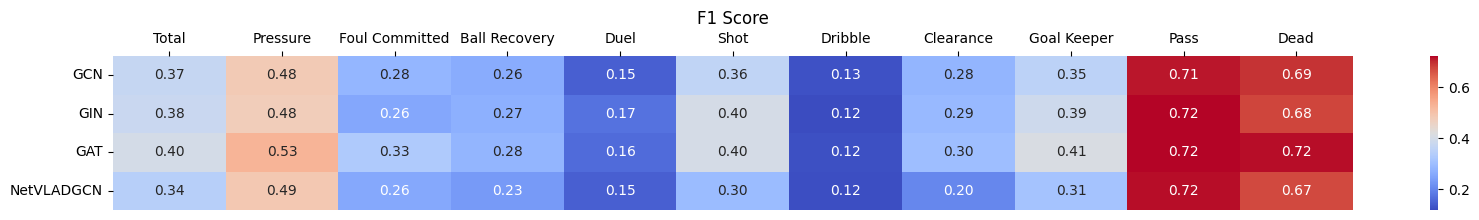

In [5]:
titles = ["MAP", "Precision", "Recall", "F1 Score"]
cols = ["Total"] + list(event_enc.keys())
rows = ["GCN", "GIN", "GAT", "NetVLADGCN"]
metrics = [map_scores, precisions, recalls, f1_scores]
for i, metric in enumerate(metrics):
    fig = plt.figure(figsize=(20, 2))
    ax = sns.heatmap(metric, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
    ax.set_xticklabels(cols, rotation=0)
    ax.xaxis.tick_top()
    ax.set_yticklabels(rows, rotation=0)

    plt.title(titles[i])
    plt.show()

In [5]:
map_scores

array([[0.25602216, 0.24227126, 0.16746032, 0.0919817 , 0.03947501,
        0.24134507, 0.03940813, 0.17013423, 0.21556628, 0.41051544,
        0.94206415],
       [0.26176509, 0.2451397 , 0.14514586, 0.09833171, 0.05170081,
        0.28932573, 0.0366264 , 0.16920763, 0.23003046, 0.39756753,
        0.95457509],
       [0.27323455, 0.26444006, 0.16984131, 0.09828221, 0.04538797,
        0.30607889, 0.03582513, 0.17516271, 0.2595163 , 0.41033636,
        0.96747459],
       [0.23059326, 0.2358954 , 0.14083612, 0.07736101, 0.03894661,
        0.181562  , 0.03413489, 0.1074702 , 0.1579773 , 0.38595518,
        0.94579393]])

In [6]:
precisions

array([[0.28282269, 0.41545613, 0.17948718, 0.18657718, 0.08561644,
        0.23978202, 0.07086614, 0.18020305, 0.23404255, 0.66038394,
        0.57581227],
       [0.28598799, 0.42043344, 0.15686275, 0.20094937, 0.10419682,
        0.26558266, 0.06706587, 0.18575064, 0.25721154, 0.65892256,
        0.54290429],
       [0.30341755, 0.44456702, 0.22222222, 0.20853081, 0.09424084,
        0.26890756, 0.06903766, 0.19220779, 0.2761194 , 0.65797392,
        0.60036832],
       [0.25885855, 0.39444995, 0.16545012, 0.16860465, 0.08707124,
        0.1862955 , 0.06812933, 0.12013536, 0.1984127 , 0.6357908 ,
        0.56424581]])

In [7]:
recalls

array([[0.65414904, 0.57614827, 0.6637931 , 0.4512987 , 0.52083333,
        0.72727273, 0.59433962, 0.64545455, 0.7173913 , 0.77098615,
        0.8739726 ],
       [0.66251935, 0.5471394 , 0.68965517, 0.41233766, 0.5       ,
        0.80991736, 0.52830189, 0.66363636, 0.77536232, 0.79747351,
        0.90136986],
       [0.69291904, 0.64947623, 0.63793103, 0.42857143, 0.625     ,
        0.79338843, 0.62264151, 0.67272727, 0.80434783, 0.80195599,
        0.89315068],
       [0.6360754 , 0.64141821, 0.5862069 , 0.37662338, 0.45833333,
        0.71900826, 0.55660377, 0.64545455, 0.72463768, 0.82233089,
        0.83013699]])

In [8]:
f1_scores

array([[0.3704038 , 0.4827819 , 0.28256881, 0.2640076 , 0.14705882,
        0.36065574, 0.12663317, 0.28174603, 0.35294118, 0.71141192,
        0.69423286],
       [0.3768571 , 0.4754902 , 0.25559105, 0.27021277, 0.17245509,
        0.4       , 0.11902232, 0.29025845, 0.38628159, 0.72160767,
        0.67765191],
       [0.39787867, 0.52783235, 0.32962138, 0.2805526 , 0.16378526,
        0.40167364, 0.12429379, 0.2989899 , 0.41111111, 0.72286501,
        0.71806167],
       [0.34462119, 0.4884934 , 0.25806452, 0.23293173, 0.14634146,
        0.29591837, 0.12139918, 0.20256776, 0.31152648, 0.71712864,
        0.67184035]])

Data preprocessing:   0%|          | 0/1 [00:00<?, ?it/s]

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


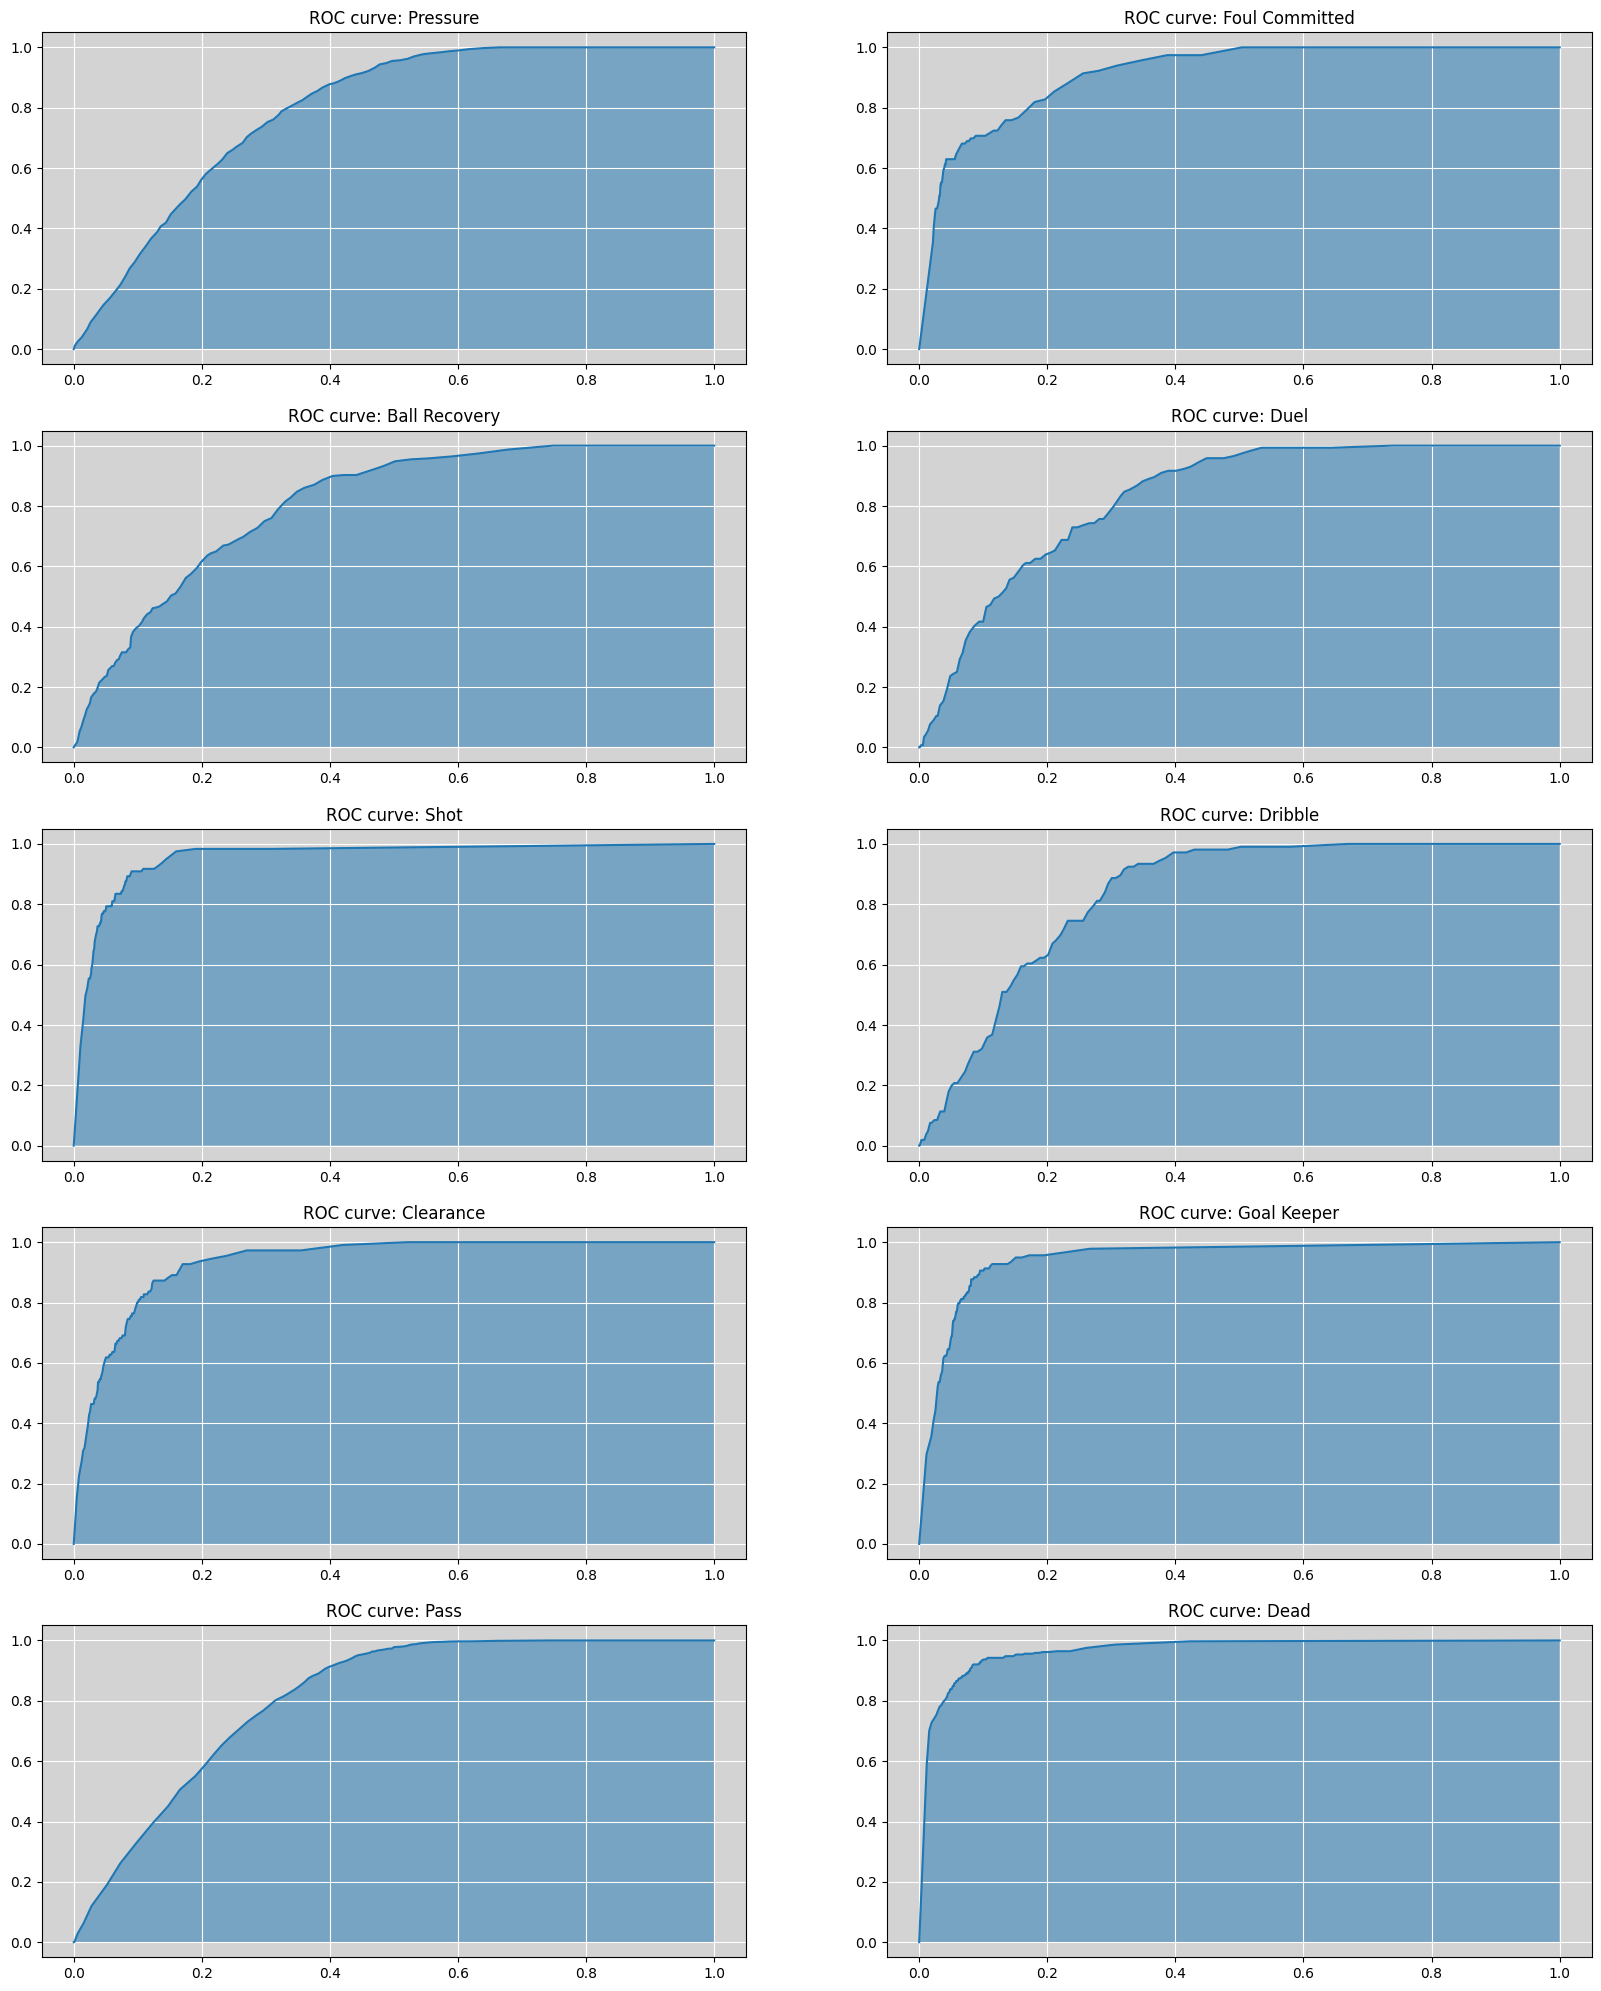

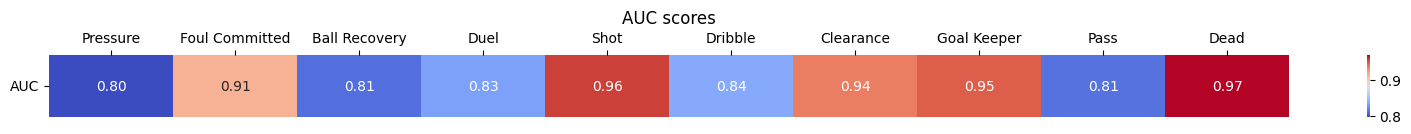

In [12]:
args = Args()
path =  "models/spotting_GAT.pth.tar"
for key, value in model_paths[path].items():
    setattr(args, key, value)
selected_model = torch.load(path)
game_analyser = GamaAnalysis(args, selected_model)

# Calculate map_score
AUC = game_analyser.all_test_games_evaluation(args, last_game_index=4, seg_model=False, calibrate=True, type_eval="clip_based_ROC_AUC")

cols = list(event_enc.keys())

fig = plt.figure(figsize=(20,0.8))
ax = sns.heatmap(np.array(AUC).reshape(1,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(["AUC"], rotation=0)

plt.title("AUC scores")
plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:10<00:00, 10.29s/it]


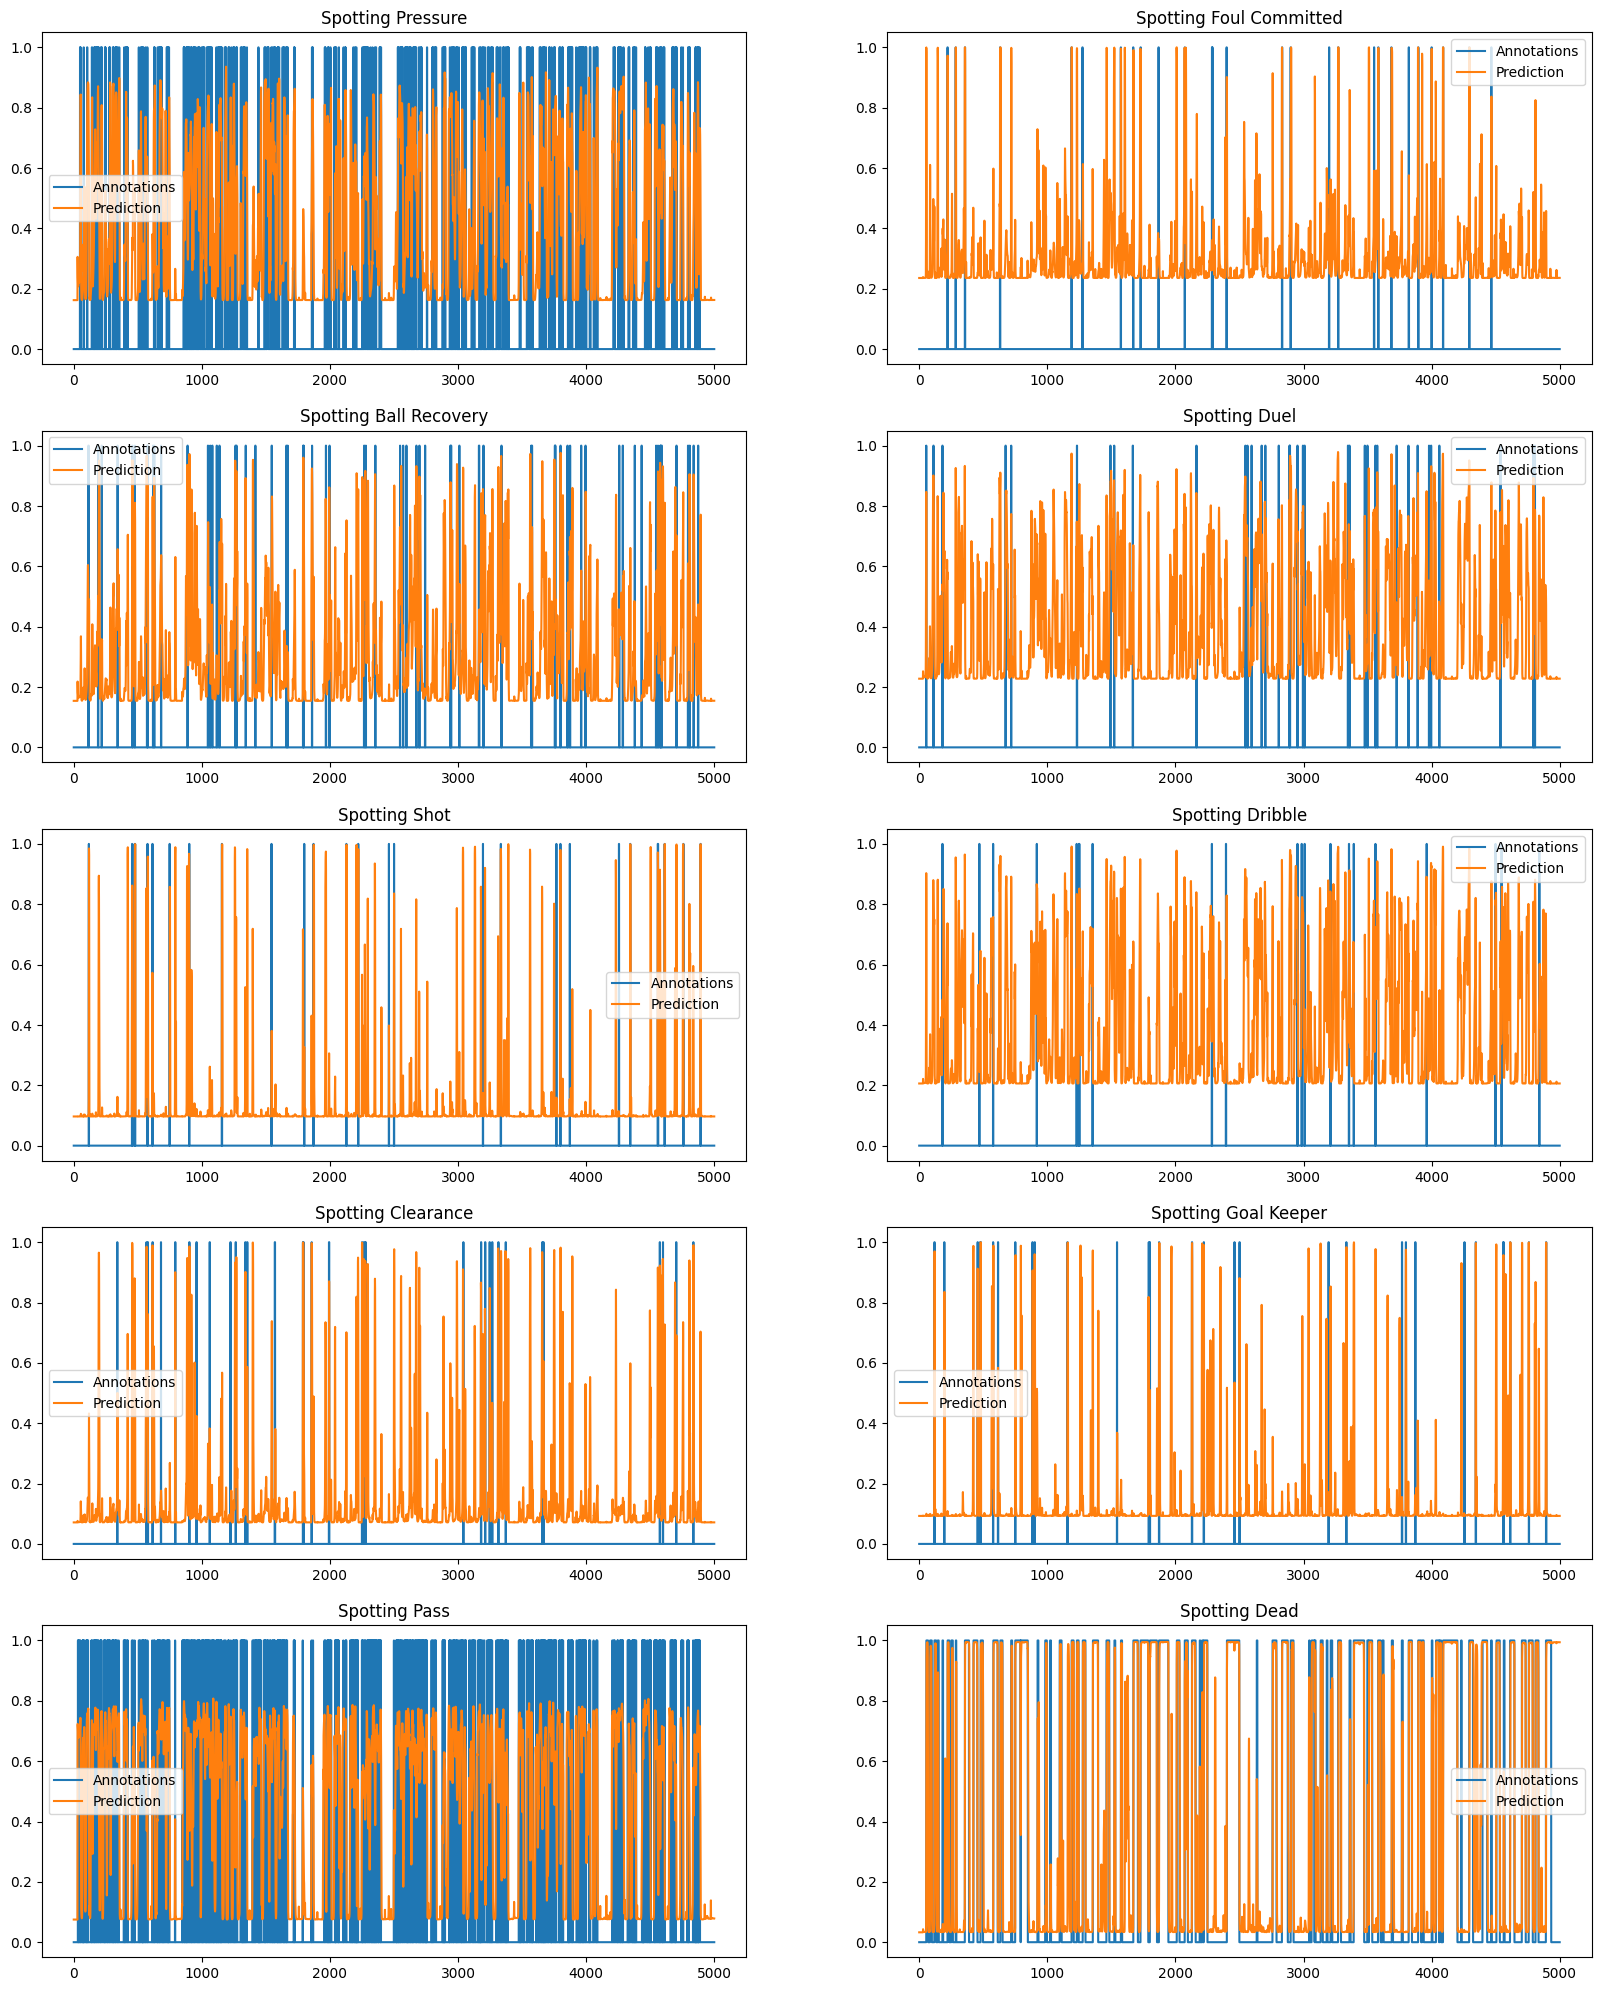

(<Figure size 2000x2500 with 10 Axes>,
 array([[<Axes: title={'center': 'Spotting Pressure'}>,
         <Axes: title={'center': 'Spotting Foul Committed'}>],
        [<Axes: title={'center': 'Spotting Ball Recovery'}>,
         <Axes: title={'center': 'Spotting Duel'}>],
        [<Axes: title={'center': 'Spotting Shot'}>,
         <Axes: title={'center': 'Spotting Dribble'}>],
        [<Axes: title={'center': 'Spotting Clearance'}>,
         <Axes: title={'center': 'Spotting Goal Keeper'}>],
        [<Axes: title={'center': 'Spotting Pass'}>,
         <Axes: title={'center': 'Spotting Dead'}>]], dtype=object))

In [10]:
args = Args()
path =  "models/spotting_GAT.pth.tar"
for key, value in model_paths[path].items():
    setattr(args, key, value)
selected_model = torch.load(path)
game_analyser = GamaAnalysis(args, selected_model)
game_analyser.predict_game(0, seg_model=False, calibrate=True, ann=None)
game_analyser.plot_predictions(5000, annotation=None) 

In [ ]:
game_analyser.plot_predictions(5000, annotation=None)

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.90s/it]


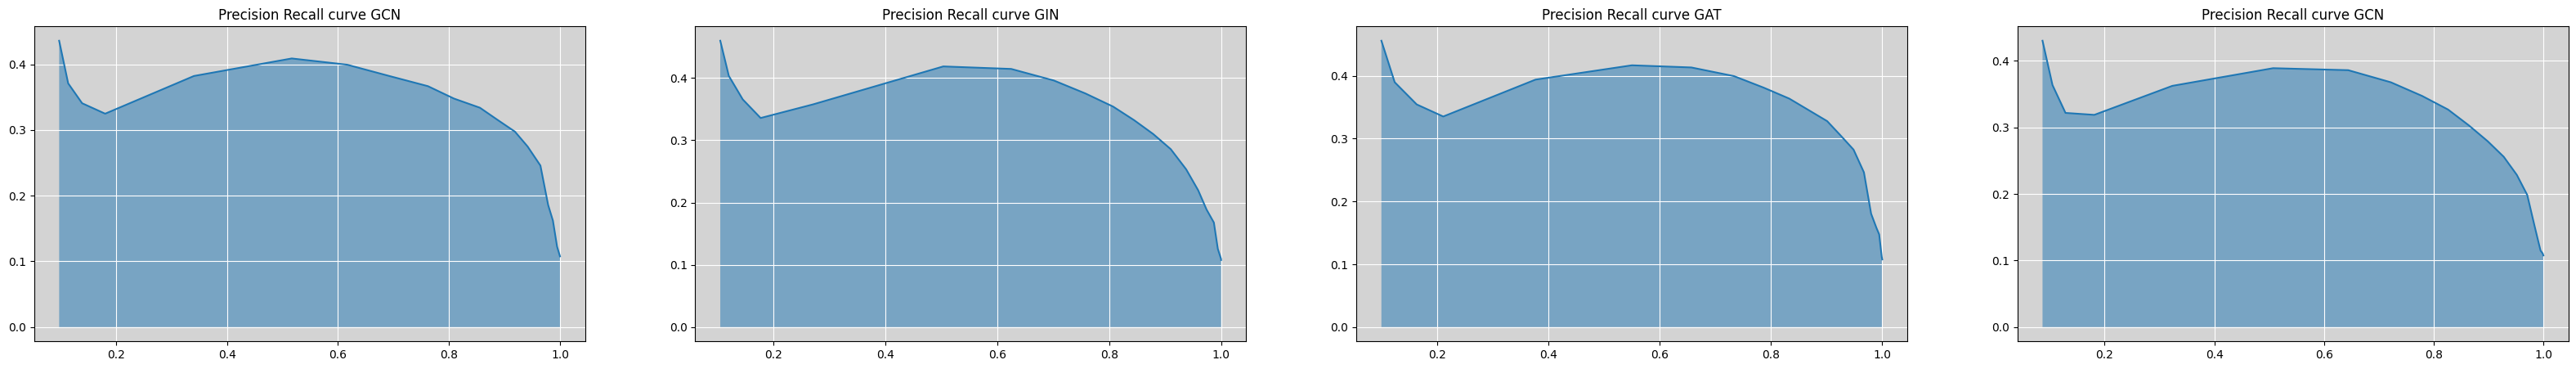

In [7]:
args = Args
cols = 4
rows = 1
fig, axes = plt.subplots(rows, cols, figsize=(10*cols, 5*rows))

for path, ax in zip(model_paths.keys(), axes.flatten()):
    for key, value in model_paths[path].items():
        setattr(args, key, value)
    
    model = torch.load(path)
    game_analyser = GamaAnalysis(args, model)
    precision, recall = game_analyser.all_test_games_evaluation(args, last_game_index=4, seg_model=False, calibrate=True, ann=None, type_eval="precision_recall_curve")

    ax.plot(recall, precision)
    ax.set_title(f"Precision Recall curve {args.backbone_player}")
    ax.set_facecolor('lightgray') 
    ax.grid(True, color='white')
    ax.fill_between(recall, precision, alpha=0.5)